# Face Recogniton and Siamese Model - Attendance System

## Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
from keras_facenet import FaceNet
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
from utils.face_mtcnn import *
import csv
import datetime

### Loading model

In [2]:
embedder = FaceNet()

### Loading images

In [4]:
base_dir = "data/train_images"
persons = os.listdir(base_dir)
images = {}
# image_paths = []
for person in persons:
    images[person] = []
    paths = os.listdir(os.path.join(base_dir,person))[:20]
    for path in paths:
        # image_paths.append(os.path.join(base_dir,person,path))
        images[person].append(cv2.cvtColor(cv2.imread((os.path.join(base_dir,person,path))),cv2.COLOR_BGR2RGB))
print("Total number of people found = ", len(images))


Total number of people found =  5


(-0.5, 639.5, 639.5, -0.5)

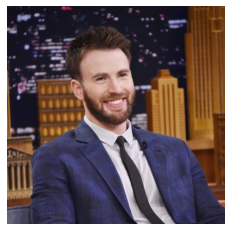

In [5]:
#sample image
plt.imshow(images['Chris'][2] , cmap = "gray")
plt.axis("off")

### Face Detection and Cropping

In [6]:
def Face_detection(images):
    ''' it will detect the face in a image 
        and will return a list of cropped images containing only face.
        
        input: list of image path on working directory
    
    '''
    
    crop_img = {}
    
    # faceCascade= cv2.CascadeClassifier("utils/haarcascade_frontalface_default.xml")
    for a in images.keys():
        crop_img[a] = []
        for img in images[a]:
            faces = detect_Faces_img(img)
            if len(faces) != 0:
                for b in faces:
                    (x,y,w,h) = b['box']
                    Cropped = img[y : y + h , x: x+w ]
                    crop_img[a].append(Cropped)  
        
    return crop_img

In [7]:
# cropped images
Crop_Images = Face_detection(images)

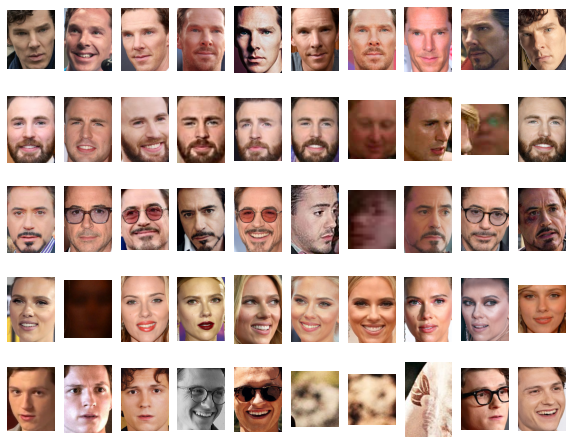

In [15]:
#plotting various faces found in our dataset!

fig , ax = plt.subplots(len(Crop_Images), 10 , figsize = (10,8))
i=1
for a in Crop_Images.keys():
    for j in range(10):
        plt.subplot(5,10,i)
        plt.axis("off")
        plt.imshow(Crop_Images[a][j])
        i += 1


### Embedding Extraction

In [16]:
embeddings = {}
for a in Crop_Images.keys():
    embeddings[a] = embedder.embeddings(Crop_Images[a])

In [17]:
#creating a database for people we expect to visit us.
database_size = 15
database = {}
for person in persons:
    database[str(person)] = embeddings[person][:database_size]
        
database

{'Ben': array([[-0.01795235, -0.02363339, -0.00272107, ..., -0.00244025,
         -0.02164875, -0.03304688],
        [ 0.00653491, -0.03710211,  0.03456181, ...,  0.00255678,
         -0.07484119, -0.07949927],
        [ 0.02244692, -0.06320552,  0.01371151, ..., -0.01638585,
         -0.01576116, -0.08940025],
        ...,
        [-0.00097043, -0.04510593, -0.01267014, ..., -0.01128064,
         -0.01556867, -0.05951291],
        [ 0.02499934, -0.04119886, -0.00526078, ..., -0.00745176,
         -0.02826968, -0.09729429],
        [ 0.01008983, -0.03202945, -0.04619657, ...,  0.00762982,
         -0.00918749, -0.05240936]], dtype=float32),
 'Chris': array([[-0.0055648 ,  0.00074927, -0.00499368, ..., -0.00654497,
         -0.00625115, -0.02765532],
        [ 0.00478883,  0.05520652,  0.0302975 , ...,  0.04145797,
          0.06674298, -0.03033403],
        [ 0.00169894, -0.01162907,  0.03835968, ...,  0.00347304,
         -0.00251313, -0.02639206],
        ...,
        [-0.03949274,  

In [11]:
database['Ben'].shape

(15, 512)

### Testing

In [12]:
def save_attendance(present):


    # open the file in the write mode
    f = open('log.csv', 'a')

    # create the csv writer
    writer = csv.writer(f)
    for a in present:
        # write a row to the csv file
        writer.writerow([a, datetime.datetime.now()])

    # close the file
    f.close()

In [21]:
def Face_recog(image_path , alpha = 2, output_file = False):
    '''
    image_path : list of individual input image path.
    alpha : it is a hyperparameter
    '''
    
    #detecting face
    img = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
    faces = detect_Faces_img(img)
    crop_imgs = []
    if len(faces) != 0:
        for b in faces:
            (x,y,w,h) = b['box']
            Cropped = img[y : y + h , x: x+w ]
            crop_imgs.append(Cropped)  

    present = []
 
    img_embedding = embedder.embeddings(crop_imgs)
    # for crop in crop_imgs:
    #     img_embedding.append(embedder.embeddings(crop))
    
    #calculate dist wrt to database images
    min_dist = 100
    i=0
    min_dists = []
    for embedding in img_embedding:
        for (name,db_emb) in database.items():
            
            for emb in db_emb:
            
                dist = np.linalg.norm(embedding - emb)
                
                if dist < min_dist:
                    min_dist = dist
                    identity = name
        
        plt.axis("off")
        plt.imshow(crop_imgs[i])
        plt.show()
        i += 1    
        if min_dist > alpha:
            print("Not found in Database")
            
        else:
            print(f"{identity} identified")
            present.append(identity)
    
    if output_file:
        save_attendance(present)
    

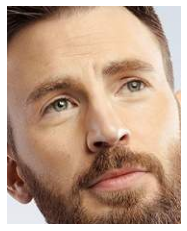

Chris identified


In [22]:
test_img_path = 'data/test/00000042.jpeg'
Face_recog(test_img_path, output_file= True)

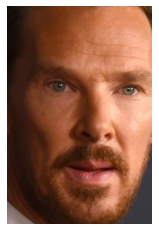

Ben identified


In [23]:
test_img_path = 'data/test/00000082.jpeg'
Face_recog(test_img_path, output_file=True)

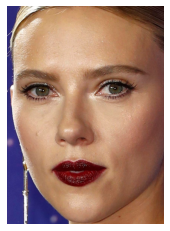

Scarlett identified


In [26]:
test_img_path = 'data/test/00000063.jpeg'
Face_recog(test_img_path, output_file=True)

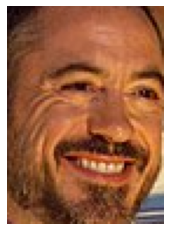

Robert identified


In [25]:
test_img_path = 'data/test/00000053.jpeg'
Face_recog(test_img_path, output_file=True)

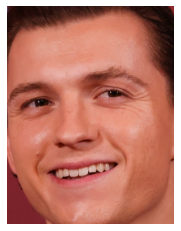

Tom identified


In [28]:
test_img_path = 'data/test/00000074.jpeg'
Face_recog(test_img_path)

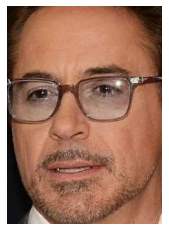

Robert identified


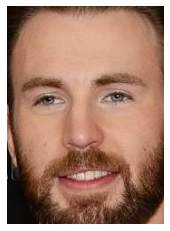

Chris identified


In [62]:
test_img_path = 'data/test/test0.jpg'
Face_recog(test_img_path)

In [ ]:
## Saving and Loading embeddings

In [42]:
emb_np = np.array(embeddings)

from numpy import save

save('emb.npy', emb_np)

In [52]:
from numpy import load
# load array
data = load('emb.npy', allow_pickle=True)
# print the array

d = dict(enumerate(data.flatten(), 1))[1]
print((d))

{'Ben': array([[-0.01795235, -0.02363339, -0.00272107, ..., -0.00244025,
        -0.02164875, -0.03304688],
       [ 0.00653491, -0.03710211,  0.03456181, ...,  0.00255678,
        -0.07484119, -0.07949927],
       [ 0.02244692, -0.06320552,  0.01371151, ..., -0.01638585,
        -0.01576116, -0.08940025],
       ...,
       [-0.09171294, -0.01909925,  0.02846508, ...,  0.01910345,
        -0.01646489,  0.02015427],
       [ 0.01109733, -0.05463086, -0.01084698, ..., -0.00220068,
        -0.01810937, -0.07862443],
       [ 0.02844808, -0.04888353,  0.00266314, ..., -0.01430789,
        -0.03989685, -0.09473755]], dtype=float32), 'Chris': array([[-0.0055648 ,  0.00074927, -0.00499368, ..., -0.00654497,
        -0.00625115, -0.02765532],
       [ 0.00478883,  0.05520652,  0.0302975 , ...,  0.04145797,
         0.06674298, -0.03033403],
       [ 0.00169894, -0.01162907,  0.03835968, ...,  0.00347304,
        -0.00251313, -0.02639206],
       ...,
       [-0.04049173,  0.01662066, -0.03702

In [ ]:
### Alter algo